## Visión por Computador

**Grupo 17**:

- Sara Expósito Suárez
- Alejandro Padrón Ossorio

Paquetes necesarios

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt

TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



Diametro: 3.000200033187866 Cantidad: 2
Diametro: 133.02593994140625 Cantidad: 2.01
Diametro: 182.1453857421875 Cantidad: 2.21
Diametro: 153.72555541992188 Cantidad: 2.23
Diametro: 197.85752868652344 Cantidad: 2.73
Diametro: 161.0204315185547 Cantidad: 2.83
Diametro: 189.7214813232422 Cantidad: 3.83
Diametro: 173.4219512939453 Cantidad: 3.88
Diametro: 211.2457733154297 Cantidad: 5.88


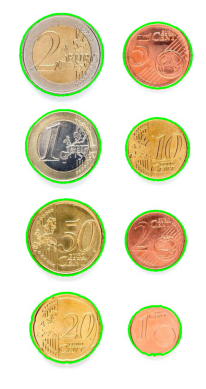

In [6]:
img = cv2.imread('Monedas.jpg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
img_gris = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

img_ggris = cv2.GaussianBlur(img_gris, (7, 7), 0)

th,img_th = cv2.threshold(img_ggris,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

contornos, hierarchy = cv2.findContours(img_th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img_rgb, contornos, -1, (0, 255, 0), 3)

selected_radius = None

def select_coin(event, x, y, flags, param):
    global selected_radius
    if event == cv2.EVENT_LBUTTONDOWN:
        for c in contornos:
            (cx, cy), radio = cv2.minEnclosingCircle(c)
            if cv2.pointPolygonTest(c, (x, y), False) >= 0:
                selected_radius = radio
                break

cv2.imshow("Selecciona la moneda de 1 euro", img)
cv2.setMouseCallback("Selecciona la moneda de 1 euro", select_coin)

while selected_radius is None:
    if cv2.waitKey(10) == 27:
        break

coins_diameter = [16.26, 18.75, 21.25, 19.75, 22.25, 24.25, 23.25, 25.75]
coins_value = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1, 2]
coins_color = ["copper", "copper", "copper", "gold", "gold", "gold", "silver_gold", "silver_gold"]

if selected_radius:
    ratio = selected_radius * 2 / coins_diameter[6]

money_amount = 0
tolerance = 3

def get_avg_color(contornos, img_hsv):
    mask = np.zeros(img_hsv.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, contornos, -1, 255, -1)
    mean_value = cv2.mean(img_hsv, mask=mask)
    return mean_value[:3]

def classify_color_hsv(avg_color):
    h, s, v = avg_color
    
    if 10 < h < 20 and s > 100:
        return "copper"
    elif 20 < h < 30 and s > 100:
        return "gold"
    
    return "silver_gold"

for c in contornos:
    (cx, cy), radio = cv2.minEnclosingCircle(c)
    diameter = radio * 2
    detected = False
    
    avg_color = get_avg_color(c, img_hsv)
    color = classify_color_hsv(avg_color)
    
    for coin_diameter, coin_value, coin_color in zip(coins_diameter, coins_value, coins_color):
        if abs(diameter - ratio * coin_diameter) < tolerance:
            money_amount += coin_value
            detected = True
            break

    if not detected:
        money_amount += coins_value[-1]
    
    print("Diametro:", diameter, "Cantidad:", money_amount)

# print(money_amount)
plt.imshow(img_rgb)
plt.axis("off")

cv2.destroyAllWindows()

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno